In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely as sp
import fiona
import pyproj as pp
import six as six
import geopandas as gpd
import seaborn as sns
from shapely import wkt

from matplotlib import pyplot as plt
from urllib.request import urlopen
from plotly import graph_objects as go
from plotly import express as px
from sklearn.feature_extraction.text import CountVectorizer
from geopy.distance import geodesic

import os

plt.style.use('fivethirtyeight')

In [48]:
covid = pd.read_csv('/users/jonmale/Documents/GitHub/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

In [49]:
map_df = gpd.read_file('/users/jonmale/Downloads/c_03mr20/c_03mr20.shp')

In [50]:
covid.head(15)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20
0,16.0,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,...,0,0,0,0,0,0,0,0,0,0
1,316.0,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,...,113,121,121,128,130,133,133,133,133,135
2,580.0,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,...,6,6,6,6,6,6,6,6,6,6
3,630.0,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,...,513,573,620,683,725,788,897,903,923,974
4,850.0,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,...,43,43,45,45,50,51,51,51,51,51
5,84001001.0,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,12,12,12,15,17,19,19,19,23,24
6,84001003.0,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,38,42,44,56,59,66,71,72,87,91
7,84001005.0,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2,3,3,4,9,9,10,10,11,12
8,84001007.0,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,7,8,9,9,11,13,16,17,17,18
9,84001009.0,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,10,10,10,11,12,12,13,14,16,17


In [51]:
print(covid.dtypes)

UID        float64
iso2        object
iso3        object
code3        int64
FIPS       float64
            ...   
4/11/20      int64
4/12/20      int64
4/13/20      int64
4/14/20      int64
4/15/20      int64
Length: 96, dtype: object


In [52]:
map_df.head()

,STATE,CWA,COUNTYNAME,FIPS,TIME_ZONE,FE_AREA,LON,LAT,geometry
0,ME,CAR,Washington,23029,E,se,-67.6361,45.0363,"MULTIPOLYGON (((-67.93539 44.40382, -67.93643 ..."
1,GA,CHS,McIntosh,13191,E,se,-81.2646,31.5329,"MULTIPOLYGON (((-81.46814 31.33980, -81.46747 ..."
2,GA,CHS,Liberty,13179,E,se,-81.2103,31.7093,"POLYGON ((-81.30807 31.79454, -81.30546 31.791..."
3,AS,PPG,Swains Island,60040,S,None,-171.0459,-11.0843,"POLYGON ((-171.04049 -11.08245, -171.03940 -11..."
4,AS,PPG,Manu'a,60020,S,None,-169.5060,-14.2219,"MULTIPOLYGON (((-169.61275 -14.15533, -169.611..."


### Great let's do some scrubbing to both sets

In [53]:
map_df = map_df[['STATE', 'CWA', 'COUNTYNAME', 'LON', 'LAT', 'geometry']]
covid = covid[['iso2','Admin2', 'Province_State','Country_Region','Lat','Long_','Combined_Key','1/22/20','1/23/20','1/24/20','1/25/20','1/26/20','1/27/20','1/28/20','1/29/20','1/30/20','1/31/20',
               '2/1/20','2/2/20','2/3/20','2/4/20','2/5/20','2/6/20','2/7/20','2/8/20','2/9/20','2/10/20','2/11/20','2/12/20','2/13/20','2/14/20','2/15/20','2/16/20','2/17/20','2/18/20','2/19/20','2/20/20','2/21/20','2/22/20','2/23/20','2/24/20','2/25/20','2/26/20','2/27/20','2/28/20','2/29/20',
               '3/1/20','3/2/20','3/3/20','3/4/20','3/5/20','3/6/20','3/7/20','3/8/20','3/9/20','3/10/20','3/11/20','3/12/20','3/13/20','3/14/20','3/15/20','3/16/20','3/17/20','3/18/20','3/19/20','3/20/20','3/21/20','3/22/20','3/23/20','3/24/20','3/25/20','3/26/20','3/27/20','3/28/20','3/29/20','3/30/20','3/31/20',
               '4/1/20','4/2/20','4/3/20','4/4/20','4/5/20','4/6/20','4/7/20','4/8/20','4/9/20','4/10/20','4/11/20','4/12/20','4/13/20','4/14/20','4/15/20']]

In [54]:

filtered = covid['iso2'] == 'US'

In [55]:
cont = covid[filtered]

In [56]:
cont = cont[~cont.Combined_Key.str.contains('Grand Princess')]

In [57]:
cont = cont[~cont.Combined_Key.str.contains('Diamond Princess')]

In [58]:
cont = cont[~cont.Combined_Key.str.contains('Unassigned')]

In [59]:
cont = cont[~cont.Combined_Key.str.contains('Out of')]

In [61]:
map_df = map_df[~map_df.STATE.str.contains('AS')]

In [62]:
map_df = map_df[~map_df.STATE.str.contains('PR')]

In [63]:
map_df = map_df[~map_df.STATE.str.contains('GU')]

In [64]:
map_df = map_df[~map_df.STATE.str.contains('VI')]

In [65]:
map_df = map_df[~map_df.STATE.str.contains('MP')]

In [66]:
map_df = map_df[~map_df.STATE.str.contains('HI')]

In [67]:
map_df = map_df[~map_df.STATE.str.contains('AK')]

### Great, we limited it to the contiguous US in both data sets simply for visualization purposes. Let's take a peek at the map to make sure it came out 

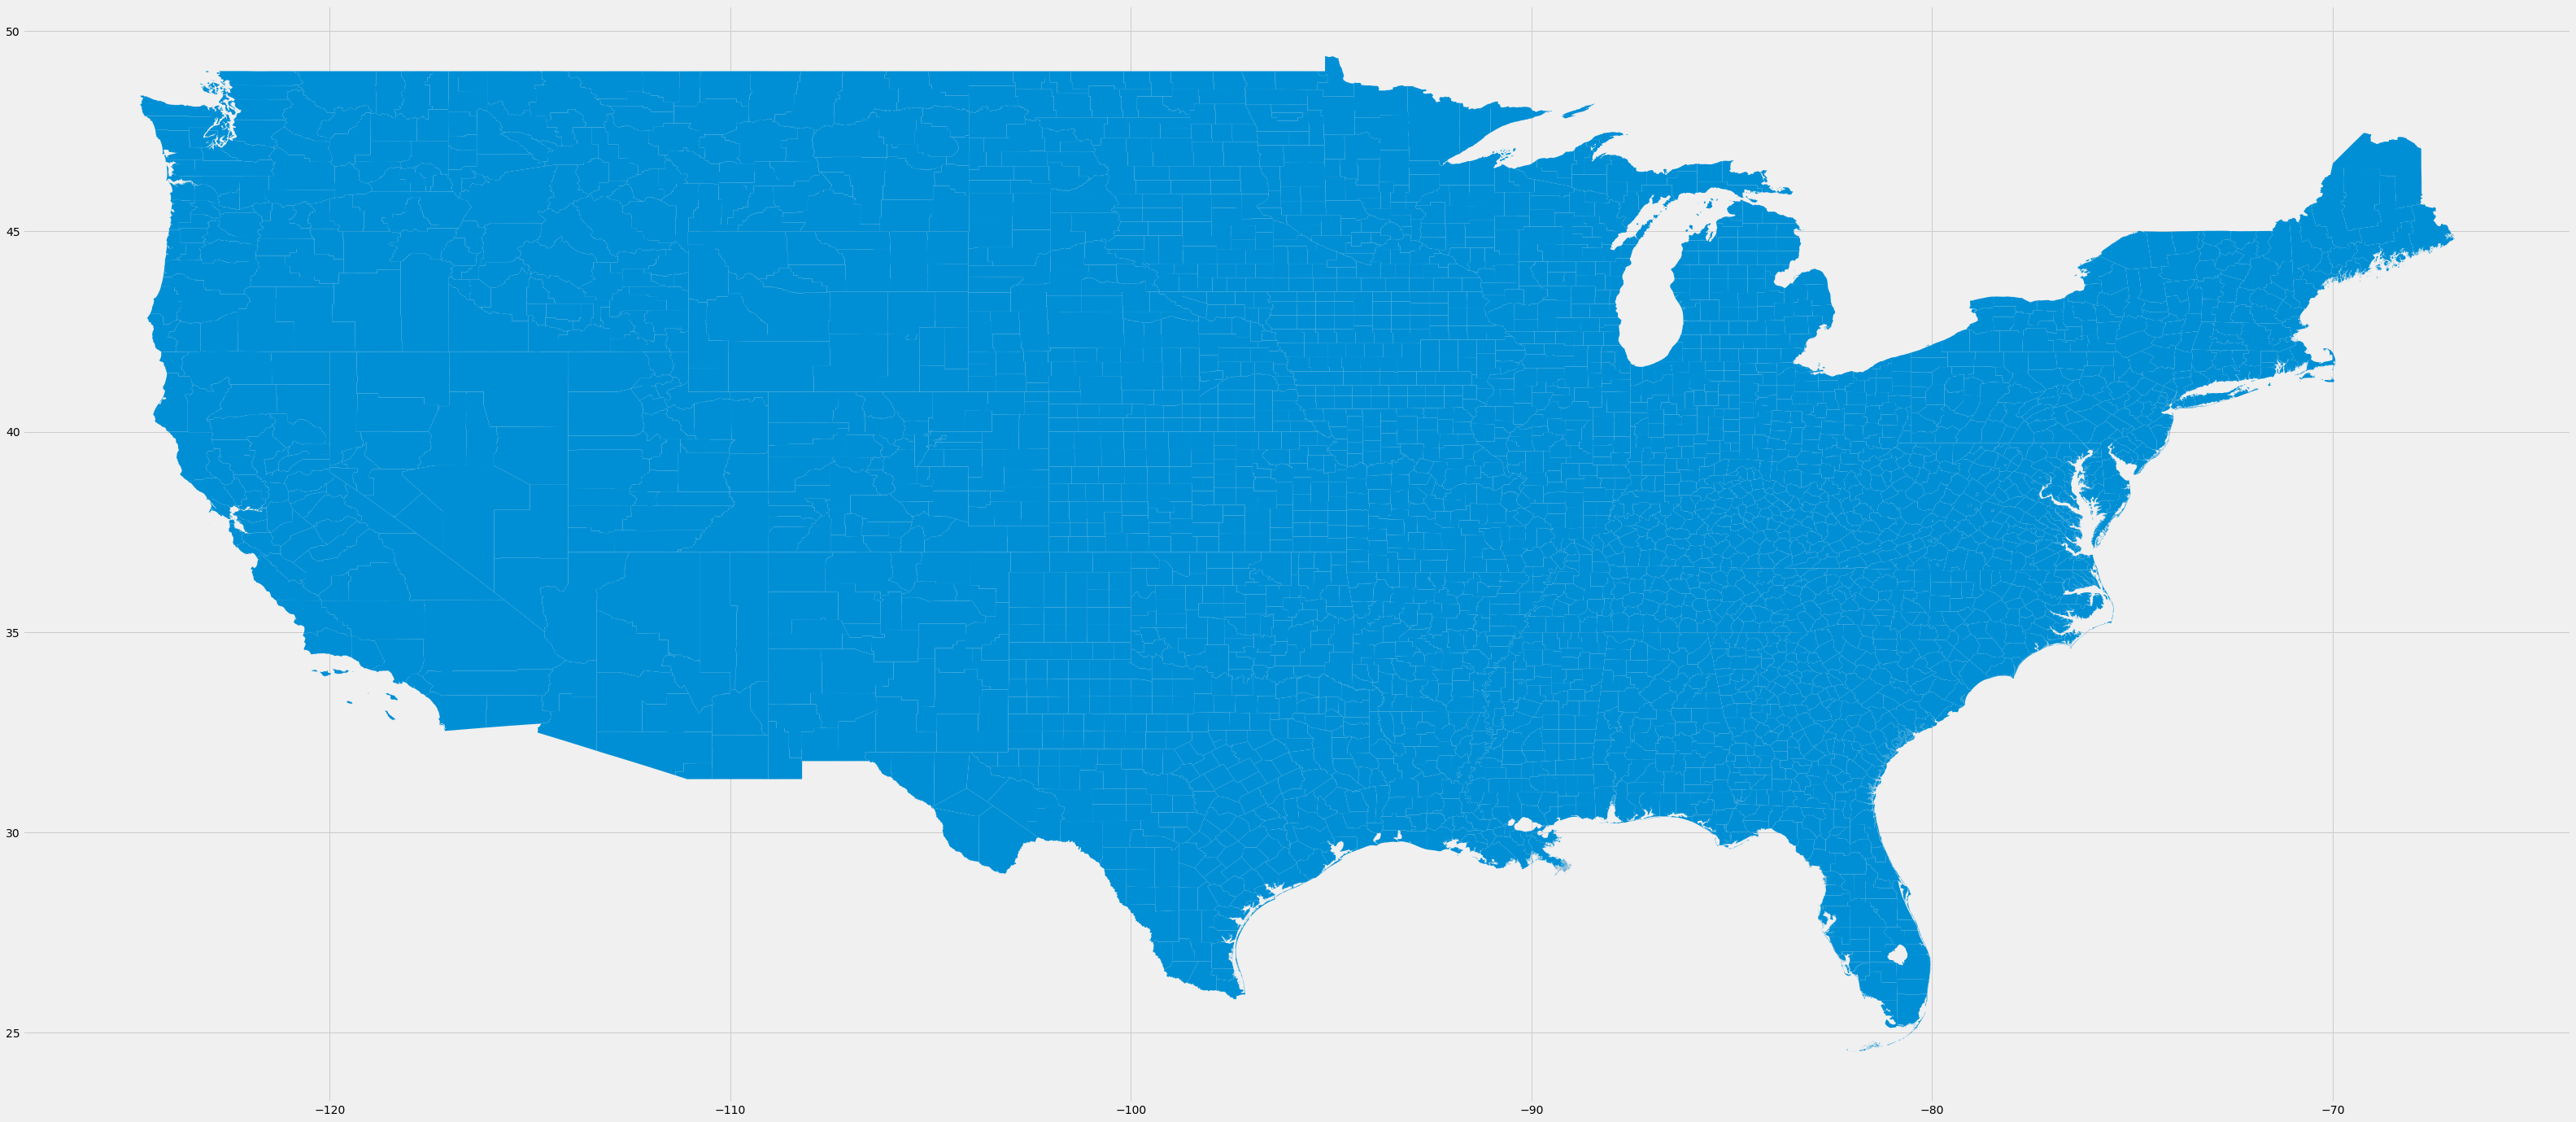

In [68]:
fig,ax = plt.subplots(1,1, figsize=(50,50))
map_df.plot(ax=ax)


plt.show()

### Next, we'll convert the COVID data to geosptaial points and merge the data. Ran into some issues with the crs, but it seems resolved

In [69]:
cont = gpd.GeoDataFrame(cont, geometry=gpd.points_from_xy(cont.Long_, cont.Lat))

In [70]:
map_df = gpd.GeoDataFrame(map_df, geometry='geometry')

In [71]:
cont_clean = cont[cont.geometry.type == 'Point']
#map_df =map_df[map_df.geometry.type == 'Polygon']
map_clean =map_df[map_df.geometry.type == 'MULTIPOLYGON']

In [72]:
cont.crs = {'init': 'epsg:4326', 'no_defs': True}

In [73]:
map_df.crs = {'init': 'epsg:4326', 'no_defs': True}

In [74]:
cont_clean.crs = {'init': 'epsg:4326', 'no_defs': True}

In [75]:
map_clean.crs = {'init': 'epsg:4326', 'no_defs': True}

In [76]:
cont_clean.to_crs(epsg=4326)
map_clean.to_crs(epsg=4326)

/Users/jonmale/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.



,STATE,CWA,COUNTYNAME,LON,LAT,geometry


In [77]:
cont.rename(columns={'Admin2':'COUNTYNAME'}, inplace=True)

In [78]:
joined = gpd.sjoin(map_df, cont, how='inner', op='intersects')

#merged = map_df.set_index('Admin2').join(map_df.set_index('COUNTYNAME'))

In [79]:
joined.head()

,STATE,CWA,COUNTYNAME_left,LON,LAT,geometry,index_right,iso2,COUNTYNAME_right,Province_State,...,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20
0,ME,CAR,Washington,-67.6361,45.0363,"MULTIPOLYGON (((-67.93539 44.40382, -67.93643 ...",1196,US,Washington,Maine,...,1,1,1,1,1,1,1,1,1,2
91,CT,BOX,Hartford,-72.7328,41.8064,"POLYGON ((-72.89799 42.03781, -72.86250 42.037...",314,US,Hartford,Connecticut,...,882,1045,1045,1471,1615,1832,1914,2243,2370,2570
92,CT,BOX,Tolland,-72.3365,41.8550,"POLYGON ((-72.50919 42.03411, -72.48330 42.033...",319,US,Tolland,Connecticut,...,103,111,111,145,152,171,182,195,201,216
93,CT,BOX,Windham,-71.9875,41.8299,"POLYGON ((-72.06350 42.02731, -72.04250 42.027...",320,US,Windham,Connecticut,...,40,43,43,52,59,66,66,83,87,89
95,MD,PBZ,Garrett,-79.2739,39.5286,"POLYGON ((-78.99060 39.72251, -78.93130 39.722...",1208,US,Garrett,Maryland,...,3,3,5,5,4,4,4,4,4,4


### Alright our data is merged and the COVID data should fill the bounds of the counties associated. Let's map it with some conservative max amounts per county

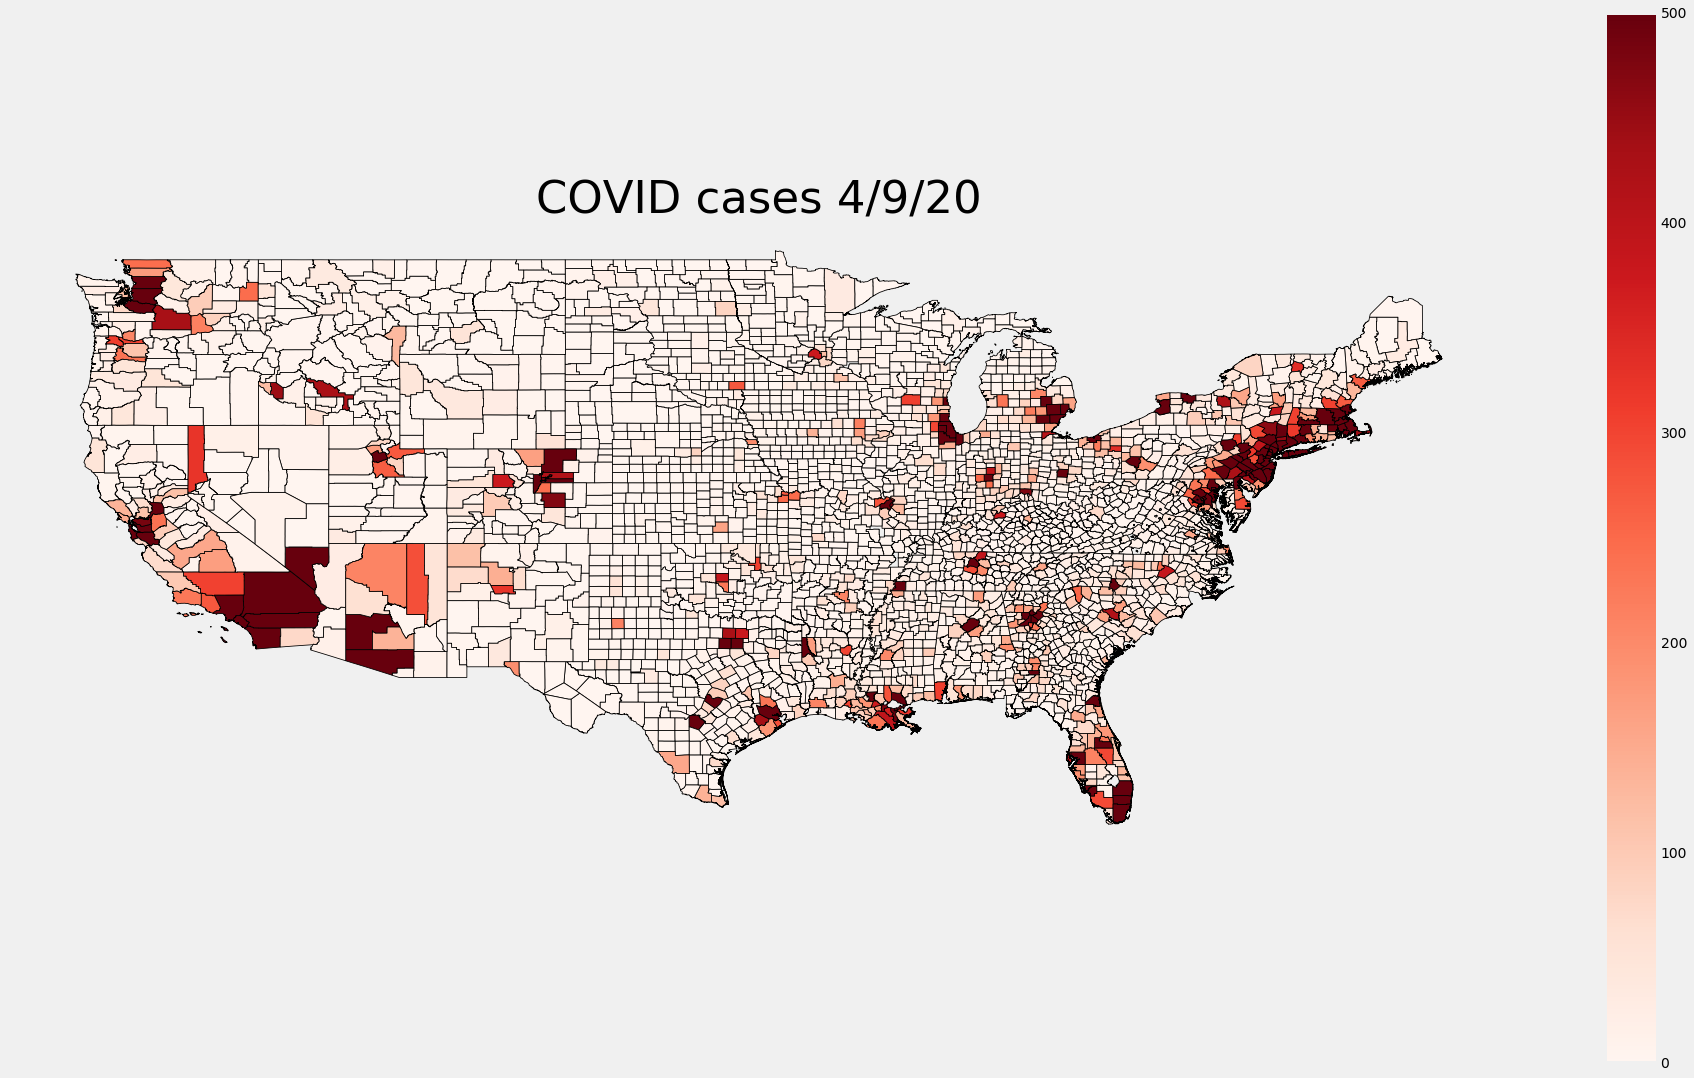

In [84]:
vmin, vmax = 0, 500

fig, ax = plt.subplots(1, figsize=(30, 18))

joined.plot(column="4/9/20",cmap='Reds', ax=ax, legend=True, linewidth=0.8, edgecolor="black", norm=plt.Normalize(vmin=vmin, vmax=vmax))

ax.axis('off')

ax.set_title('COVID cases 4/9/20', \
              fontdict={'fontsize': '45',
                        'fontweight' : '10',
                        'fontname':'DejaVu Sans'})
            
fig.savefig('testmap.png', dpi=300)


#### Great our example works and we can start churning out examples to render into a gif or video

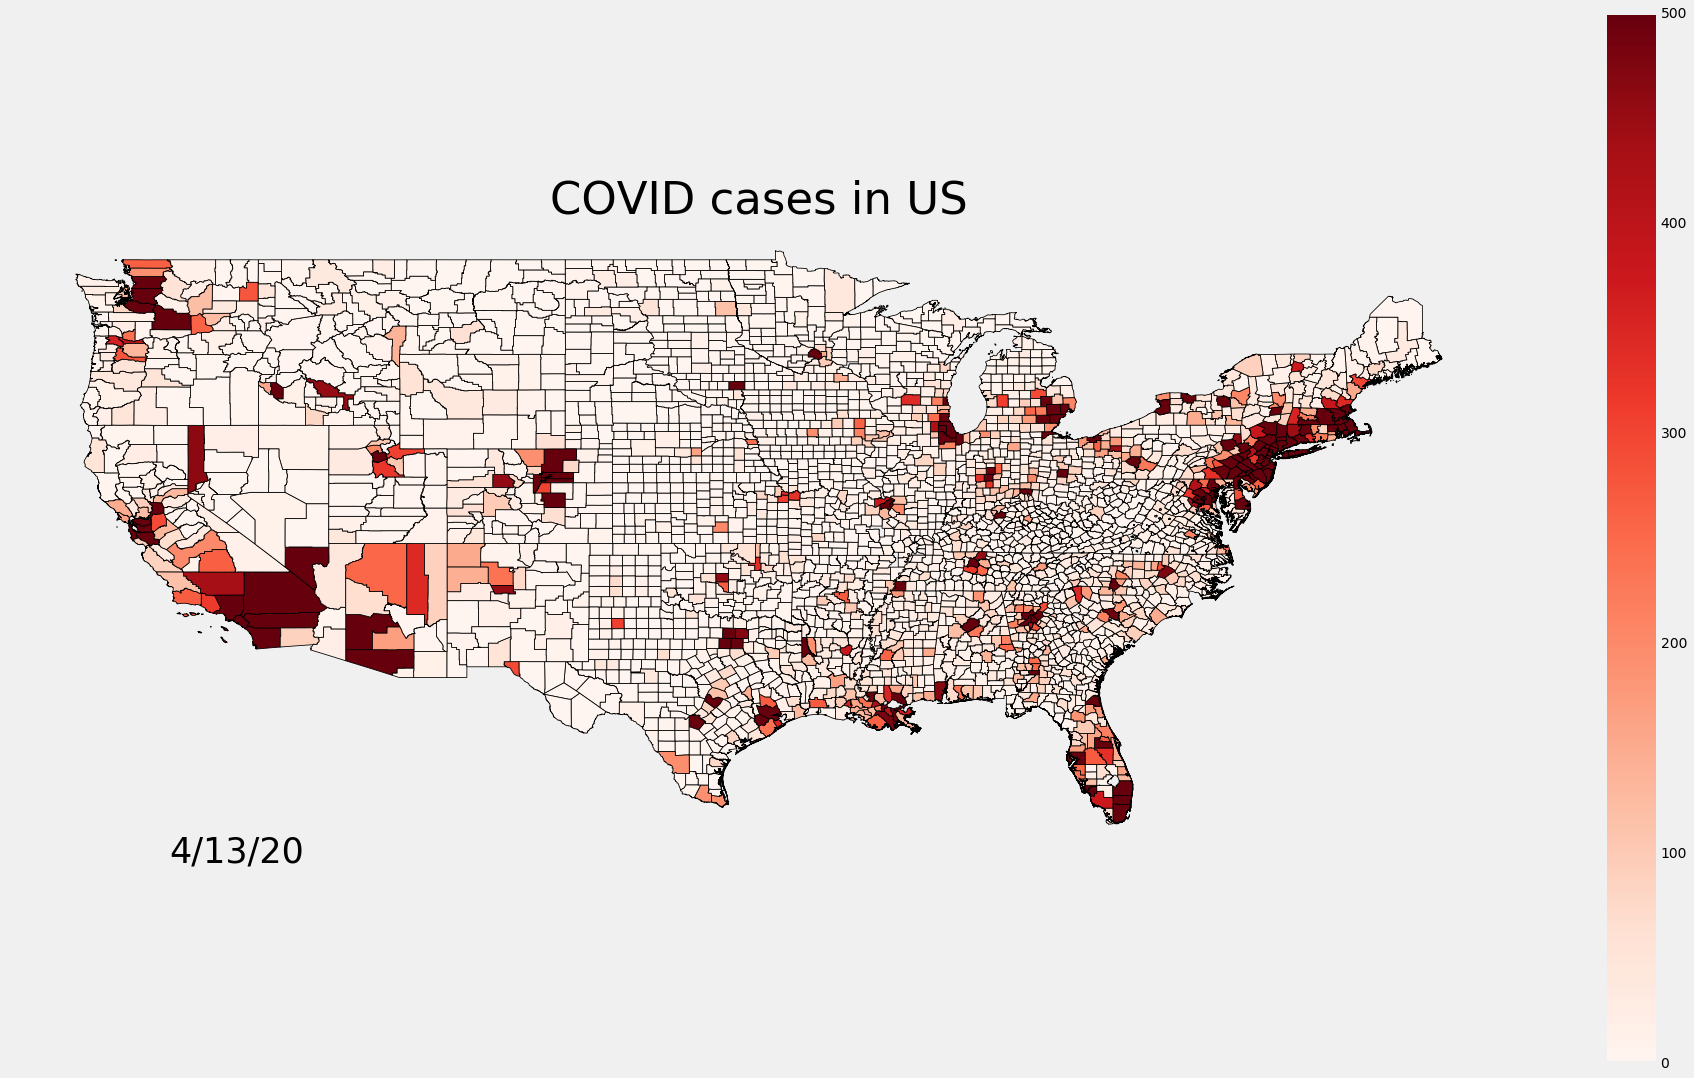

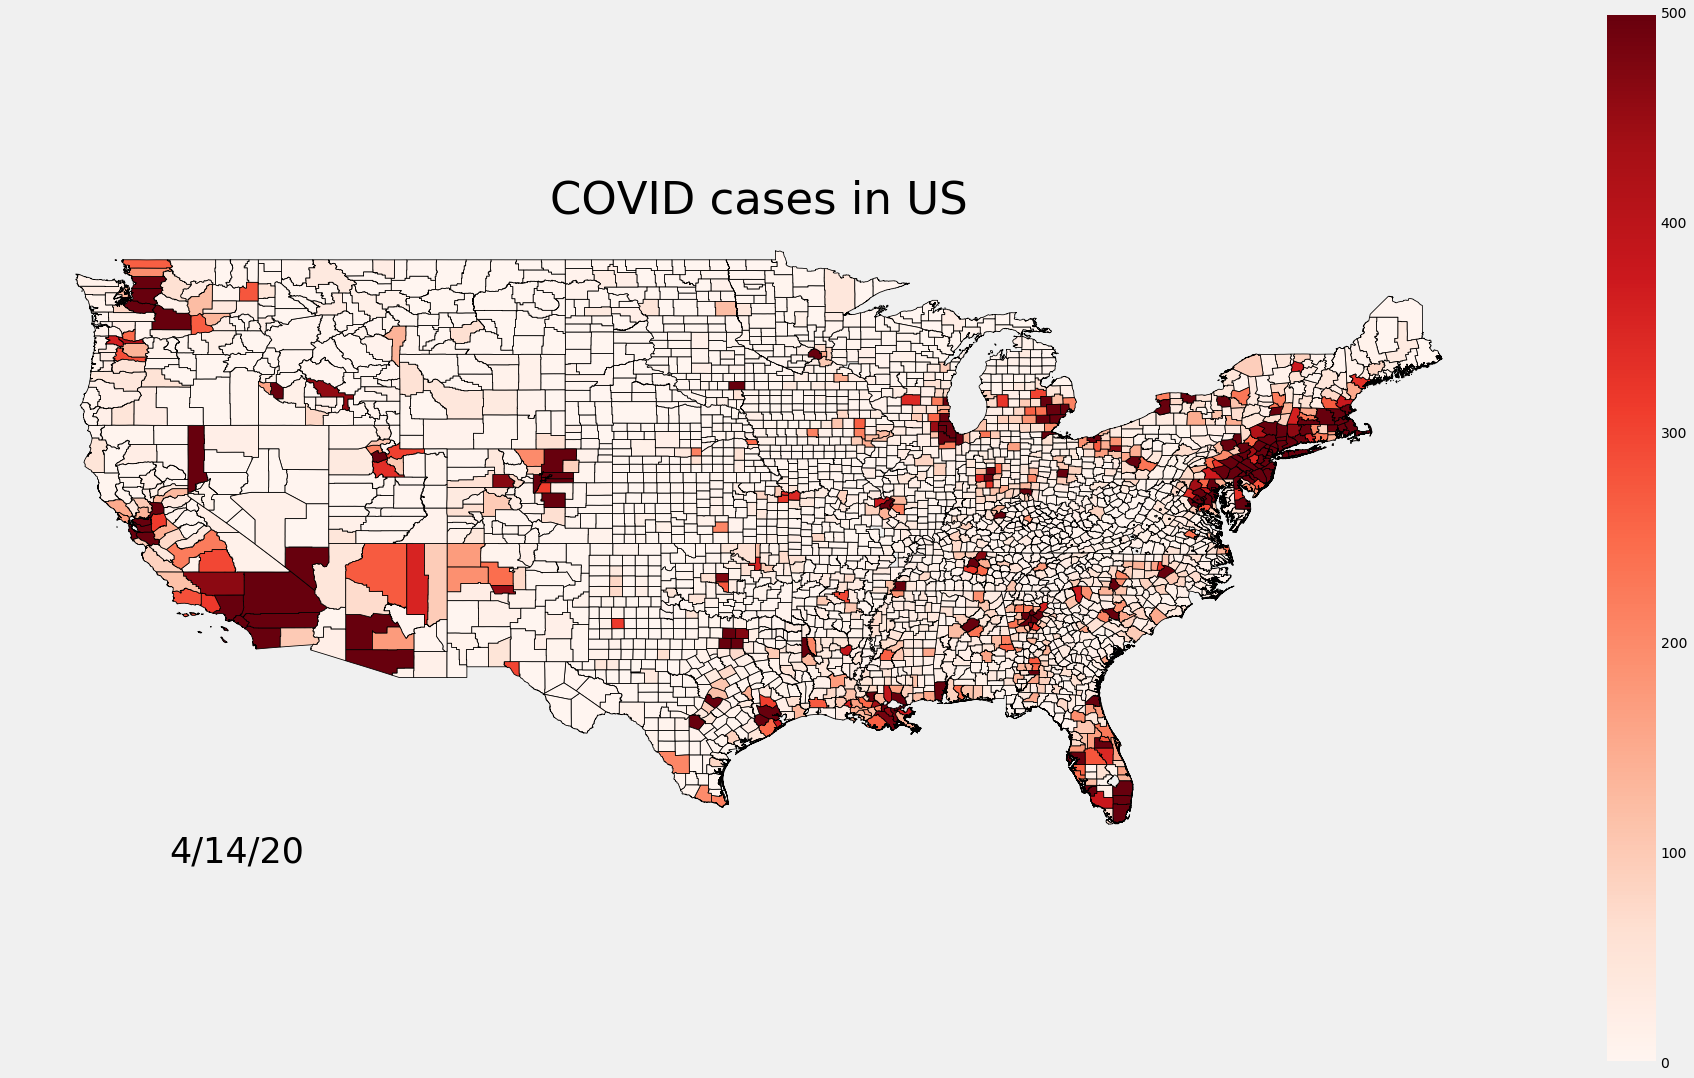

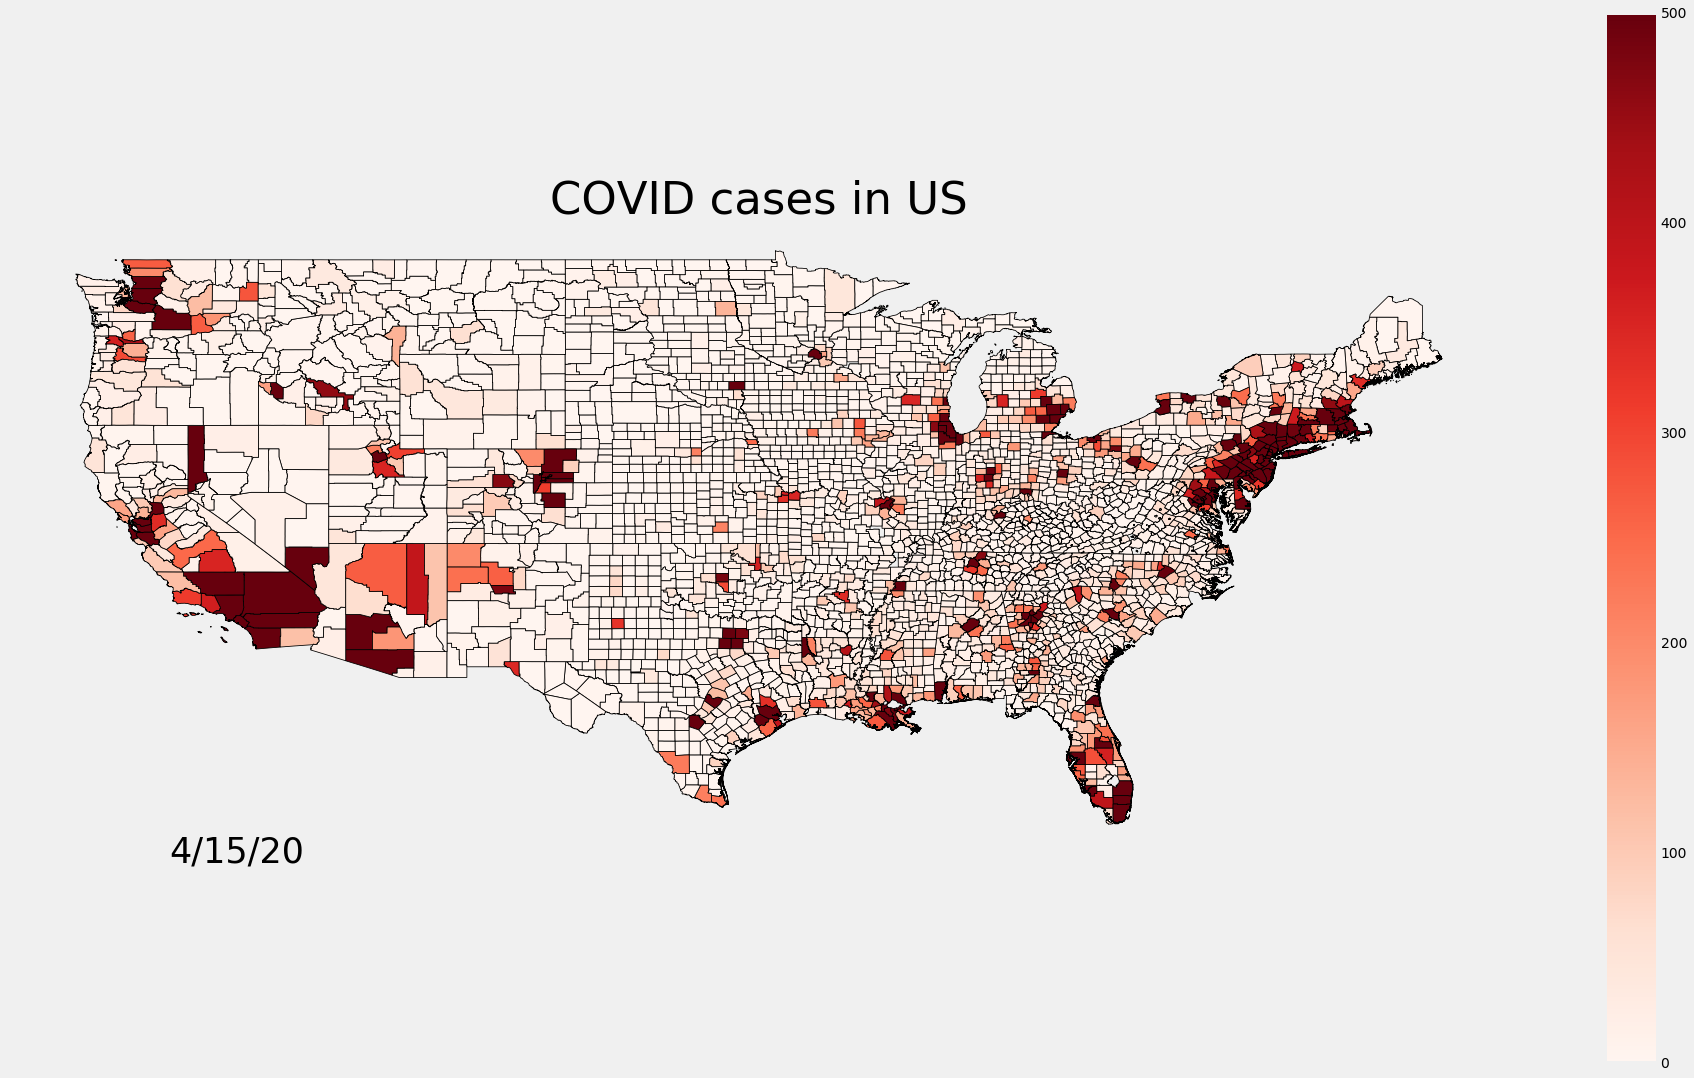

In [81]:
output_path = '/users/jonmale/Documents/charts/maps'

i = 0 
list_of_dates = ['4/13/20','4/14/20','4/15/20']
                 
vmin, vmax = 0, 500

for date in list_of_dates:
    
    fig = joined.plot(column=date, cmap='Reds', figsize=(30,18), linewidth=0.8, edgecolor="black", vmin=vmin, vmax=vmax, legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax)) 
    
    fig.axis('off')
    
    fig.set_title('COVID cases in US', \
              fontdict={'fontsize': '45',
                         'fontweight' : '10'})
    
    only_date = date[:]
    day = date[2:4]
    
    fig.annotate(only_date,
        xy=(0.1, .225), xycoords='figure fraction',
        horizontalalignment='left', verticalalignment='top',
        fontsize=35)
    
    filepath = os.path.join(output_path, day+'_COVID.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)